In [1]:
%run Data_Import_Cleaning.ipynb
tech_data = get_tech_data()
course_data = get_course_data()

## Tech Exploratory Data Analysis

In the EDA I want to look at different things related to the technician information. Things such as:
1. Currently employed vs former technicians
2. Number of techs over time
3. Technician tenure
4. others as thought of

In [2]:
tech_data.head()

,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
0,Liftow Limited,Full-Line,NS,05520,"Bobcat Atlantic, Dartmouth, NS",00000093,1,2004-10-16,2017-03-03,DEACTIVATED,12.38
1,"Best Line Leasing, Inc.",Full-Line,PA,01436,"Best Line Leasing, Inc, Pennsdale, PA",00000107,1,2004-10-16,2020-01-07,DEACTIVATED,15.23
2,"Streacker Tractor Sales, Inc.",Construction,OH,08788,"Streacker Tractor Sales, Inc, Findlay, OH",00000153,1,2004-10-16,NaT,ACTIVATED,19.57
3,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00000204,1,2004-10-16,2014-05-14,DEACTIVATED,9.57
4,"Smith Bros. Contracting Equipment, Inc.",Full-Line,FL,05469,"Bobcat of Palm Beach, West Palm Beach, FL",00000231,1,2004-10-16,2008-02-15,DEACTIVATED,3.33


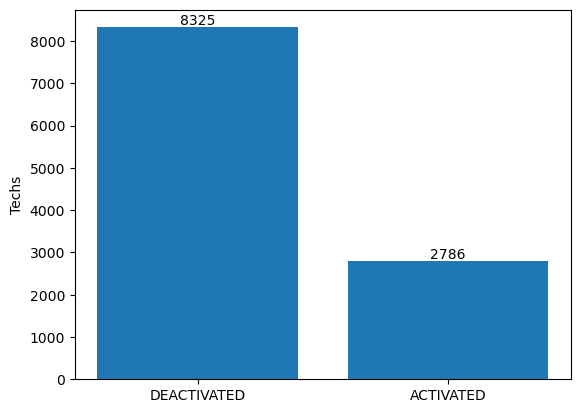

In [3]:
# active vs non-active techs
fig, ax = plt.subplots()
counts = tech_data['Account_Control'].value_counts().values
labs = tech_data['Account_Control'].value_counts().index
rects = ax.bar(labs, counts)
ax.bar_label(rects, counts)
ax.set_ylabel("Techs")

plt.show()

In [4]:
# Getting a single DF that counts terminated and starting by date
techs_start_date = tech_data.groupby('Start_dt').agg({'Employees': ['count']})
techs_term_date = tech_data.groupby('Term_dt').agg({'Employees': ['count']})
techs_date = techs_start_date.merge(techs_term_date, how='outer', left_index=True, right_index=True)

# Want date to be column not index for graphing purposes
techs_date.reset_index(inplace=True)
techs_date.columns = ['Date', 'Starting', 'Terminated']

#Will be grouping by month, so creating month column
techs_date['Month'] = (
    pd.to_datetime(
        dict(
            year=techs_date['Date'].dt.year, 
            month=techs_date['Date'].dt.month, 
            day=1
        )
))

In [5]:
# Summarize by month
techs_date_month = techs_date.groupby('Month').agg({'Starting': 'sum', 'Terminated': 'sum'})
techs_date_month['Growth'] = (techs_date_month['Starting'] - techs_date_month['Terminated']).astype(int)
techs_date_month['Employees'] = techs_date_month['Growth'].cumsum()
techs_date_month.reset_index(inplace=True)
techs_date_month

,Month,Starting,Terminated,Growth,Employees
0,2004-10-01,76.0,0.0,76,76
1,2004-11-01,17.0,0.0,17,93
2,2004-12-01,9.0,0.0,9,102
3,2005-01-01,6.0,0.0,6,108
4,2005-02-01,8.0,0.0,8,116
...,...,...,...,...,...
229,2023-12-01,86.0,56.0,30,2858
230,2024-01-01,136.0,117.0,19,2877
231,2024-02-01,107.0,114.0,-7,2870
232,2024-03-01,110.0,268.0,-158,2712


## Number of Employees Trending

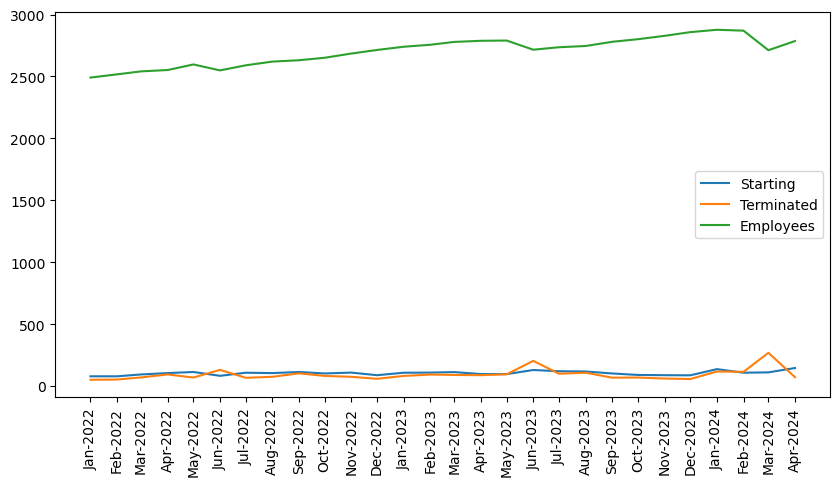

In [6]:
# Plot starting and ending counts
data = techs_date_month[techs_date_month['Month'] >= pd.to_datetime(date(2022, 1, 1))]
fig, ax1 = plt.subplots(figsize=(10,5))
x=data['Month']
cols = ['Starting', 'Terminated', 'Employees']
h=data[cols]
ax1.plot(x, h, label=cols)
ax1.legend()


plt.xticks(x, rotation=90)
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))
plt.show()

The same graph would look better if the y-axis is split

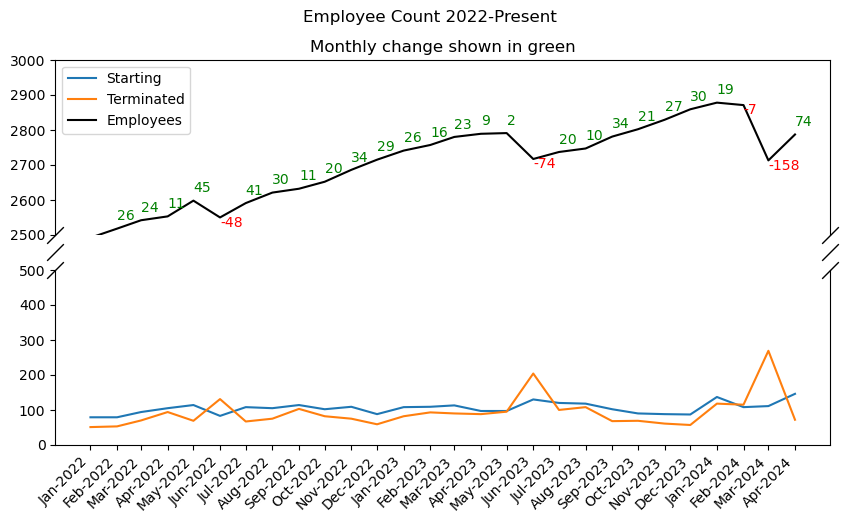

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
x=data['Month']
cols = ['Starting', 'Terminated']
h=data[cols]

fig.suptitle('Employee Count 2022-Present')
ax1.set_title('Monthly change shown in green')

ax1.plot(x, h, label=cols)
ax1.plot(x, data['Employees'], color='k', label='Employees')

ax2.plot(x, h, label=cols)
ax2.plot(x, data['Employees'], color='k')

ax1.set_ylim(2500, 3000) #highdata
ax2.set_ylim(0, 500) # Starting/Terminated data
ax1.legend()

# Adding the monthly growth for data labels
for x1, y1, lab in zip(data['Month'], data['Employees'], data['Growth']):
    if lab>=0:
        ax1.annotate(lab, xy=(x1,y1), xytext=(x1, y1+25), color='g')
    else:
        ax1.annotate(lab, xy=(x1,y1), xytext=(x1, y1-25), color='r')

# 'merging' the axis
ax1.spines.bottom.set_visible(False) #removes bottom line from topgraph
ax2.spines.top.set_visible(False) #removes top line from topgraph
ax1.xaxis.tick_top() #removes month labels for top graph
ax1.tick_params(top=False, labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

#creating the hash marks were the axis breaks
# (0,0), (0,1),(1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.
d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", # slashes won't be connected
              color='k', 
              mec='k', #marker edge color = black
              mew=1, #marker edge width
              clip_on=False #allows the slashes to appear outside of the figures
             )
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [1.1, 1.1], transform=ax2.transAxes, **kwargs)

plt.xticks(x, rotation=45, ha='right')
ax2.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))
plt.show()

In [8]:
del data

## Technician Tenure

In [9]:
tech_data.head()

,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
0,Liftow Limited,Full-Line,NS,05520,"Bobcat Atlantic, Dartmouth, NS",00000093,1,2004-10-16,2017-03-03,DEACTIVATED,12.38
1,"Best Line Leasing, Inc.",Full-Line,PA,01436,"Best Line Leasing, Inc, Pennsdale, PA",00000107,1,2004-10-16,2020-01-07,DEACTIVATED,15.23
2,"Streacker Tractor Sales, Inc.",Construction,OH,08788,"Streacker Tractor Sales, Inc, Findlay, OH",00000153,1,2004-10-16,NaT,ACTIVATED,19.57
3,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00000204,1,2004-10-16,2014-05-14,DEACTIVATED,9.57
4,"Smith Bros. Contracting Equipment, Inc.",Full-Line,FL,05469,"Bobcat of Palm Beach, West Palm Beach, FL",00000231,1,2004-10-16,2008-02-15,DEACTIVATED,3.33


In [52]:
data = tech_data
summary_stats = data['YOE'].describe()
summary_stats

count    11111.000000
mean         2.479635
std          3.367698
min          0.000000
25%          0.470000
50%          1.240000
75%          2.915000
max         19.570000
Name: YOE, dtype: float64

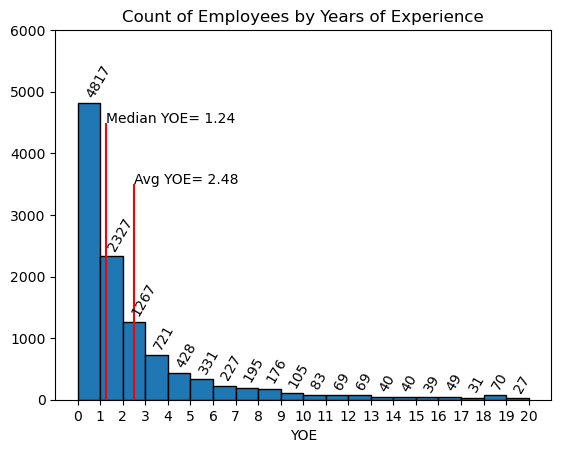

In [53]:
fig, ax = plt.subplots()
x=data['YOE']


hist, bin_edges = np.histogram(data['YOE'], range=(0,np.ceil(summary_stats['max'])), bins=20)
ax.hist(x, bin_edges, edgecolor='k')

#Adding mean and median lines
x_mean = x.mean().round(2)
ax.vlines(x_mean, ymin=0, ymax=3500, colors='r')
ax.annotate(f'Avg YOE= {x_mean}', xy=(x_mean, 3500), )

x_median = x.median()
ax.vlines(x_median, ymin=0, ymax=4500, colors='r')
ax.annotate(f'Median YOE= {x_median}', xy=(x_median, 4500), )



ax.set_title('Count of Employees by Years of Experience')
ax.set_xlabel('YOE')


for i,j in zip(hist, bin_edges):
    ax.annotate(i, xy=(j,i), rotation=60, xytext=(j+.25, i+100))
    
plt.ylim(top=6000)
plt.xticks(bin_edges)
plt.show()


In [54]:
keep_cols=['YOE', 'Account_Control']
tech_data[keep_cols].groupby('Account_Control').describe()

YOE                                                   
                  count      mean       std   min   25%   50%   75%    max
Account_Control                                                           
ACTIVATED        2786.0  3.753991  4.602865  0.06  0.68  1.86  4.84  19.57
DEACTIVATED      8325.0  2.053165  2.706185  0.00  0.42  1.11  2.50  19.36

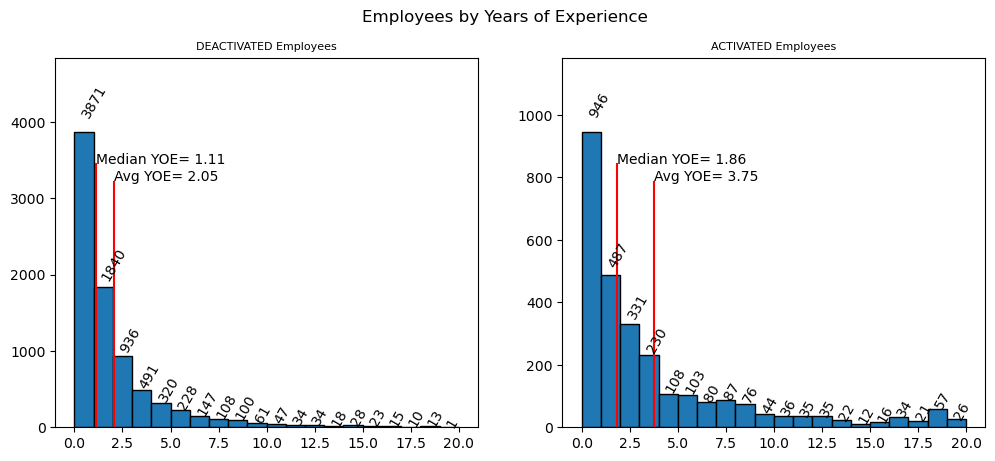

In [101]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
status = ['DEACTIVATED', 'ACTIVATED']
axes = [ax1, ax2]

for ind in [0,1]:
    x = tech_data[tech_data['Account_Control']==status[ind]]['YOE']
    hist, bin_edges = np.histogram(x, range=(0,np.ceil(summary_stats['max'])), bins=20)
    y_limit=hist.max()*1.25
    axes[ind].hist(x, bin_edges, edgecolor='k')

    #Adding mean and median lines
    x_mean = x.mean().round(2)
    axes[ind].vlines(x_mean, ymin=0, ymax=y_limit/1.5, colors='r')
    axes[ind].annotate(f'Avg YOE= {x_mean}', xy=(x_mean, y_limit/1.5), )

    x_median = x.median()
    axes[ind].vlines(x_median, ymin=0, ymax=y_limit/1.4, colors='r')
    axes[ind].annotate(f'Median YOE= {x_median}', xy=(x_median, y_limit/1.4), )

    for i,j in zip(hist, bin_edges):
        axes[ind].annotate(i, xy=(j,i), rotation=60, xytext=(j+.25, i*1.05))
        
    axes[ind].set_title(f'{status[ind]} Employees', fontsize=8)
    #axes[ind].set_xticks(bin_edges)
    axes[ind].set_ylim(0, y_limit)

plt.suptitle('Employees by Years of Experience')       
plt.show()

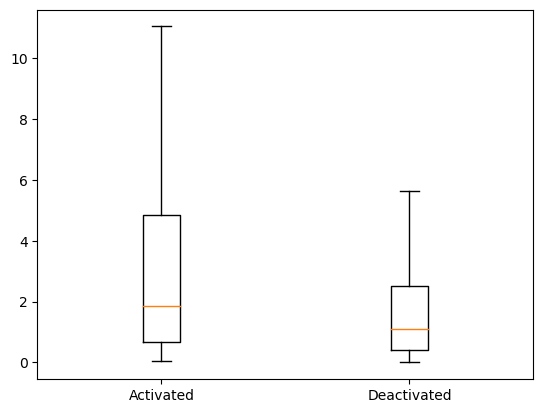

In [115]:
fig, ax = plt.subplots()
x_active= tech_data['YOE'][tech_data['Account_Control']=="ACTIVATED"]
x_deactive = tech_data['YOE'][tech_data['Account_Control']=="DEACTIVATED"]

ax.boxplot([x_active, x_deactive], labels=['Activated', 'Deactivated'], sym='')
plt.show()

In [111]:
data

,Active,Deactive
0,NaN,12.38
1,NaN,15.23
2,19.57,NaN
3,NaN,9.57
4,NaN,3.33
...,...,...
11106,0.07,NaN
11107,0.07,NaN
11108,0.06,NaN
11109,0.06,NaN
